In [2]:
import numpy as np 
import pandas as pd 
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.preprocessing import OrdinalEncoder

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

warnings.filterwarnings("ignore",  category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning,)
warnings.filterwarnings("ignore", category=UserWarning)

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


In [3]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')

### Zmiana typu kolumn numerycznych na INT64

In [4]:
cols_to_convert = ['Time_spent_Alone', 'Social_event_attendance','Going_outside',  'Friends_circle_size','Post_frequency']
train_df[cols_to_convert] = train_df[cols_to_convert].astype('Int64')

In [5]:
train_df['Drained_after_socializing' + '_MISS'] = train_df['Drained_after_socializing'].notna().astype(int)

In [6]:
# Uzupełnienie danych Yes - Yes // No- No
train_df['Stage_fear'] = train_df['Stage_fear'].mask(train_df['Stage_fear'].isna() & train_df['Drained_after_socializing']
                                            .notna(), train_df['Drained_after_socializing'])
train_df['Drained_after_socializing'] = train_df['Drained_after_socializing'].mask(train_df['Drained_after_socializing']
                                            .isna() & train_df['Stage_fear'].notna(), train_df['Stage_fear'])

In [7]:
cat_cols = ['Stage_fear','Drained_after_socializing']  # <-- tu wpisz swoje kolumny kategoryczne
train_df[cat_cols]=train_df[cat_cols].fillna('Missing').astype(str)

## dwie dobre kolumny do właczenia

In [8]:
train_df['Outside_mult_Friends'] = train_df['Going_outside'] * train_df['Friends_circle_size']
def Outside_mult_Friends (x):
    try:
        x=float(x)
        if x <= 11:
            return 0
        elif x > 11 and x <= 15:
            return 1
        elif x > 15 and x < 400:
            return 2
        else:
            return 2
    except ValueError:
        return 2

train_df['Outside_mult_Friends']=train_df['Outside_mult_Friends'].apply(Outside_mult_Friends).astype('Int64')

In [9]:
train_df['Time_Alone_dev_Outside'] = train_df['Time_spent_Alone'] / train_df['Going_outside']
train_df['Time_Alone_dev_Outside']=train_df['Time_Alone_dev_Outside'].round(2).astype(float)
def Time_Alone_dev_Outside (x):
    try:
        x=float(x)
        if x <= 1:
            return 0
        elif x > 1 and x < 2:
            return 1
        elif x >= 2 and x < 100:
            return 2
        else:
            return 3
    except ValueError:
        return 3

train_df['Time_Alone_dev_Outside']=train_df['Time_Alone_dev_Outside'].apply(Time_Alone_dev_Outside).astype('Int64')

## Dodajemy kolumny z odejmowaniem

train_df['Fri_sub_Post']=train_df['Friends_circle_size'] - train_df['Post_frequency']

train_df['Goi_sub_Post']=train_df['Going_outside'] - train_df['Post_frequency']

train_df['Goi_sub_Fri']=train_df['Going_outside'] - train_df['Friends_circle_size']

train_df['Soc_sub_Post']=train_df['Social_event_attendance'] - train_df['Post_frequency']

train_df['Soc_sub_Fri']=train_df['Social_event_attendance'] - train_df['Friends_circle_size']

train_df['Soc_sub_Goi']=train_df['Social_event_attendance'] - train_df['Going_outside']

train_df['Tim_sub_Post']=train_df['Time_spent_Alone'] - train_df['Post_frequency']

train_df['Tim_sub_Fri']=train_df['Time_spent_Alone'] - train_df['Friends_circle_size']

train_df['Tim_sub_Goi']=train_df['Time_spent_Alone'] - train_df['Going_outside']

train_df['Tim_sub_Soc']=train_df['Time_spent_Alone'] - train_df['Social_event_attendance']

## Dodatkowe kolumny z dodawaniemm

train_df['Fri_Sum_Post']=train_df['Friends_circle_size'] + train_df['Post_frequency']

train_df['Goi_Sum_Fri']=train_df['Going_outside'] + train_df['Friends_circle_size']

train_df['Goi_Sum_Post']=train_df['Going_outside'] + train_df['Post_frequency']

train_df['Soc_Sum_Post']=train_df['Social_event_attendance'] + train_df['Post_frequency']

train_df['Soc_Sum_Goi']=train_df['Social_event_attendance'] + train_df['Going_outside']

In [ ]:
train_df.info()

In [ ]:
train_df['Drained_after_socializing'].value_counts()

## CATBOOST

In [10]:
X=train_df.drop([ 'id','Personality','Stage_fear'], axis=1).copy()
y=train_df['Personality'].copy()

In [11]:
cat_features = ['Drained_after_socializing',  'Outside_mult_Friends', 'Time_Alone_dev_Outside','Drained_after_socializing_MISS']

#'Drained_after_socializing', 'Outside_mult_Friends', 'Time_Alone_dev_Outside', 
# 1. Inicjalizacja modelu (bez uczenia, bez pipeline'u)Time_Alone_dev_Outside
model = CatBoostClassifier(random_seed=42,verbose=100, cat_features=cat_features)  # verbose=0 żeby nie spamował

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. Zbiór parametrów do przeszukania
param_grid = {
    'learning_rate': [  0.04],#, 0.05, 0.1],
    'depth': [ 6],#, 8],
    #'l2_leaf_reg': [4,5,3,6],#, 3],
    'iterations': [  250], #opt 200
    #'auto_class_weights': ['SqrtBalanced'] #'Balanced', 'None', 
}

# 3. GridSearchCV (tu możesz dodać scoring, cv, n_jobs itd.)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',       # lub 'roc_auc', 'f1', zależnie od problemu
    cv=cv,                      # 5-fold cross-validation
    n_jobs=-1,                 # pełne równoległe obciążenie CPU
    return_train_score=True
)

# 4. Dopasowanie do danych (X to features, y to target)
grid_search.fit(X, y)

# 5. Wyniki
print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepszy wynik:", grid_search.best_score_)

best_model = grid_search.best_estimator_

# Ponowne fitowanie z cat_features
#best_model.set_params(cat_features=cat_features)
#best_model.fit(train_df.drop(['id','Personality'], axis=1), train_df['Personality'])
eval_pool = Pool(X, y, cat_features=cat_features)
importances = best_model.get_feature_importance(eval_pool)

res_df = pd.DataFrame(grid_search.cv_results_)
res_df[['rank_test_score','mean_test_score','mean_train_score','std_test_score','params']]

0:	learn: 0.6293924	total: 74.3ms	remaining: 18.5s
100:	learn: 0.1250639	total: 2.25s	remaining: 3.32s
200:	learn: 0.1214883	total: 4.06s	remaining: 989ms
249:	learn: 0.1200442	total: 4.82s	remaining: 0us
Najlepsze parametry: {'depth': 6, 'iterations': 250, 'learning_rate': 0.04}
Najlepszy wynik: 0.9701085439502215


,rank_test_score,mean_test_score,mean_train_score,std_test_score,params
0,1,0.970109,0.977737,0.002992,"{'depth': 6, 'iterations': 250, 'learning_rate..."


<Figure size 1000x600 with 0 Axes>

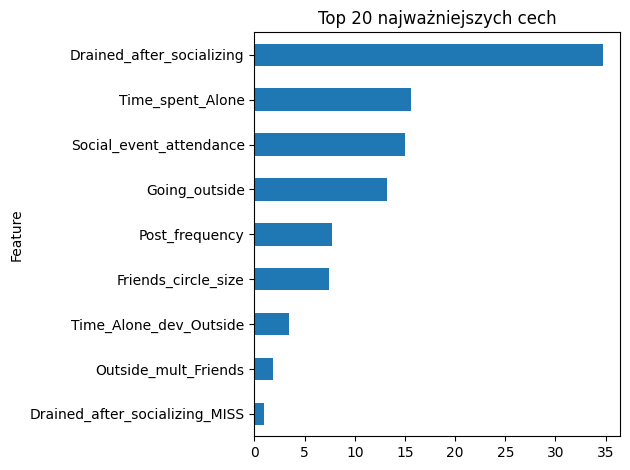

In [12]:

# Wyciągnięcie ważności cech
#importances = best_model.get_feature_importance(Pool(train_df.drop(['id','Personality'], axis=1), train_df['Personality']))
feature_names = X.columns

# DataFrame z ważnościami
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Wyświetlenie najważniejszych cech
plt.figure(figsize=(10, 6))
fi_df.head(30).plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.gca().invert_yaxis()
plt.title("Top 20 najważniejszych cech")
plt.tight_layout()
plt.show()

# __________________________________ NOWY MODEL CATBOOST TYLKO KATEGORIE _______________________________

In [127]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')

cols_to_convert = ['Time_spent_Alone', 'Social_event_attendance','Going_outside',  'Friends_circle_size','Post_frequency']
train_df[cols_to_convert] = train_df[cols_to_convert].astype('Int64')

train_df['Drained_after_socializing' + '_MISS'] = train_df['Drained_after_socializing'].notna().astype(int)

# Uzupełnienie danych Yes - Yes // No- No
train_df['Stage_fear'] = train_df['Stage_fear'].mask(train_df['Stage_fear'].isna() & train_df['Drained_after_socializing']
                                            .notna(), train_df['Drained_after_socializing'])
train_df['Drained_after_socializing'] = train_df['Drained_after_socializing'].mask(train_df['Drained_after_socializing']
                                            .isna() & train_df['Stage_fear'].notna(), train_df['Stage_fear'])

cat_cols = ['Stage_fear','Drained_after_socializing']  # <-- tu wpisz swoje kolumny kategoryczne
train_df[cat_cols]=train_df[cat_cols].fillna('Missing').astype(str)
train_df = train_df.drop('Stage_fear', axis=1)

In [128]:
excluded_cols = ['id', 'Personality', 'Drained_after_socializing_MISS']
all_columns = train_df.columns
# Przetwarzanie pozostałych kolumn
for col in all_columns:
    if col not in excluded_cols:
        train_df[col + '_MISS'] = train_df[col].notna().astype(int)

columns = ['Time_spent_Alone_MISS', 'Social_event_attendance_MISS', 'Going_outside_MISS','Drained_after_socializing_MISS', 
           'Friends_circle_size_MISS','Post_frequency_MISS']
train_df['not_MISS_total'] = train_df[columns].sum(axis=1)
train_df.drop(columns, axis=1, inplace=True)

# dwie dobre kolumny do właczenia

In [129]:
train_df['Outside_mult_Friends'] = train_df['Going_outside'] * train_df['Friends_circle_size']
def Outside_mult_Friends (x):
    try:
        x=float(x)
        if x <= 11:
            return 0
        elif x > 11 and x <= 15:
            return 1
        elif x > 15 and x < 400:
            return 2
        else:
            return 2
    except ValueError:
        return 2

train_df['Outside_mult_Friends']=train_df['Outside_mult_Friends'].apply(Outside_mult_Friends).astype('Int64')

In [130]:
train_df['Time_Alone_dev_Outside'] = train_df['Time_spent_Alone'] / train_df['Going_outside']
train_df['Time_Alone_dev_Outside']=train_df['Time_Alone_dev_Outside'].round(2).astype(float)
def Time_Alone_dev_Outside (x):
    try:
        x=float(x)
        if x <= 1:
            return 0
        elif x > 1 and x < 2:
            return 1
        elif x >= 2 and x < 100:
            return 2
        else:
            return 3
    except ValueError:
        return 3

train_df['Time_Alone_dev_Outside']=train_df['Time_Alone_dev_Outside'].apply(Time_Alone_dev_Outside).astype('Int64')

## Odejmowanie kolumn

In [29]:
train_df['Fri_sub_Post']=train_df['Friends_circle_size'] - train_df['Post_frequency']

In [ ]:
train_df['Goi_sub_Post']=train_df['Going_outside'] - train_df['Post_frequency']

In [ ]:
train_df['Goi_sub_Fri']=train_df['Going_outside'] - train_df['Friends_circle_size']

In [ ]:
train_df['Soc_sub_Post']=train_df['Social_event_attendance'] - train_df['Post_frequency']

In [ ]:
train_df['Soc_sub_Fri']=train_df['Social_event_attendance'] - train_df['Friends_circle_size']

In [131]:
train_df['Soc_sub_Goi']=train_df['Social_event_attendance'] - train_df['Going_outside']
def soc_goi (x):
    if x <= -4:
        return 0
    elif x >= -3 and x <= 3:
        return 1
    elif x > 3 and x<= 7:
        return 2
    elif x > 8:
        return 3
    else:
        return 4
train_df['Soc_sub_Goi']=train_df['Soc_sub_Goi'].apply(soc_goi).astype('Int64')

In [ ]:
train_df['Tim_sub_Post']=train_df['Time_spent_Alone'] - train_df['Post_frequency']

In [ ]:
train_df['Tim_sub_Fri']=train_df['Time_spent_Alone'] - train_df['Friends_circle_size']

In [ ]:
train_df['Tim_sub_Goi']=train_df['Time_spent_Alone'] - train_df['Going_outside']

In [132]:
train_df['Tim_sub_Soc']=train_df['Time_spent_Alone'] - train_df['Social_event_attendance']
def tim_soc (x):
    if x <= 0:
        return 0
    elif x > 0:
        return 1
    else:
        return 4
train_df['Tim_sub_Soc']=train_df['Tim_sub_Soc'].apply(tim_soc).astype('Int64')

Personality,Extrovert,Introvert
Tim_sub_Soc,,
0,97.560169,2.439831
1,7.017544,92.982456
4,69.343066,30.656934


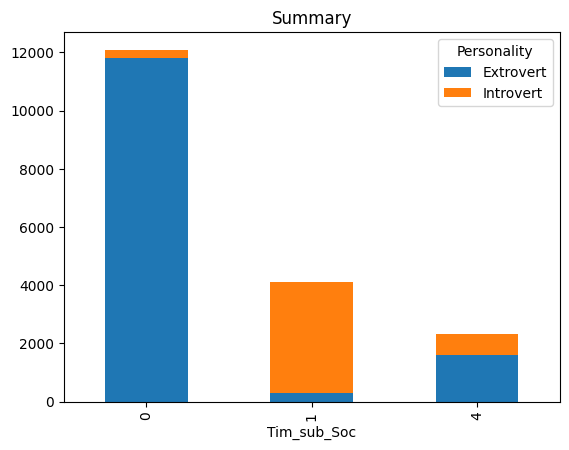

In [72]:
train_df.groupby(['Tim_sub_Soc','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')
pd.crosstab(train_df['Tim_sub_Soc'],train_df['Personality'], normalize='index')*100

##  Dodawanie kolumn

In [ ]:
train_df['Fri_Sum_Post']=train_df['Friends_circle_size'] + train_df['Post_frequency']

In [ ]:
train_df['Goi_Sum_Fri']=train_df['Going_outside'] + train_df['Friends_circle_size']

In [ ]:
train_df['Goi_Sum_Post']=train_df['Going_outside'] + train_df['Post_frequency']

train_df['Soc_Sum_Post']=train_df['Social_event_attendance'] + train_df['Post_frequency']
def soc_post (x):
    if x <= 5:
        return 0
    elif x == 6:
        return 1
    elif x >= 7 and x <= 18:
        return 2
    elif x == 19:
        return 2
    elif x > 19:
        return 2
    else:
        return 6
train_df['Soc_Sum_Post']=train_df['Soc_Sum_Post'].apply(soc_post).astype('Int64')

Personality,Extrovert,Introvert
Soc_Sum_Post,,
0,6.181917,93.818083
1,33.333333,66.666667
2,97.452907,2.547093
6,62.156536,37.843464


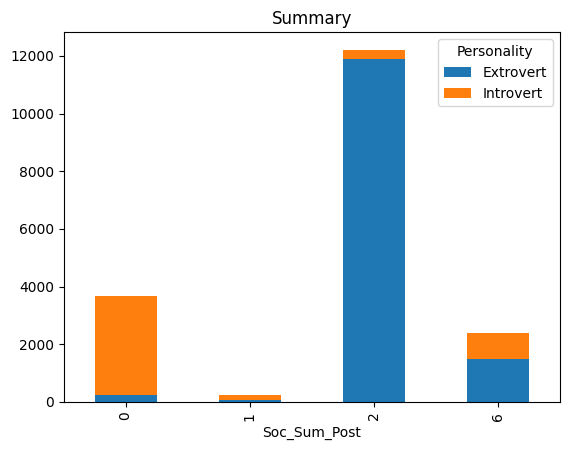

In [ ]:
train_df['Soc_Sum_Goi']=train_df['Social_event_attendance'] + train_df['Going_outside']

## Konwertujemy wszystkie kol do kategorii

In [133]:
def time_fun(x):
    if x <= 3:
        return 0
    elif x == 4:
        return 1
    elif x >= 5:
        return 2
    else:
        return 3
train_df['Time_spent_Alone']=train_df['Time_spent_Alone'].apply(time_fun).astype('Int64')

def social_fun(x):
    if x <= 2:
        return 0
    elif x == 3:
        return 1
    elif x >= 4 and x<= 9:
        return 2
    elif x >= 10:
        return 3
    else:
        return 4
train_df['Social_event_attendance']=train_df['Social_event_attendance'].apply(social_fun).astype('Int64')

def out_fun(x):
    if x <= 2:
        return 0
    elif x == 3:
        return 1
    elif x >= 4:
        return 2
    else:
        return 3
train_df['Going_outside']=train_df['Going_outside'].apply(out_fun).astype('Int64')

def friend_fun(x):
    if x <= 3:
        return 0
    elif x==4 or x==5:
        return 1
    elif x >= 6:
        return 2
    else:
        return 3
train_df['Friends_circle_size']=train_df['Friends_circle_size'].apply(friend_fun).astype('Int64')

def post_fun(x):
    if x <= 2:
        return 0
    elif x == 3:
        return 1
    elif x >= 4 and x<= 9:
        return 2
    elif x >= 10:
        return 3
    else:
        return 4
train_df['Post_frequency']=train_df['Post_frequency'].apply(post_fun).astype('Int64')

<Axes: title={'center': 'col'}, xlabel='Post_frequency'>

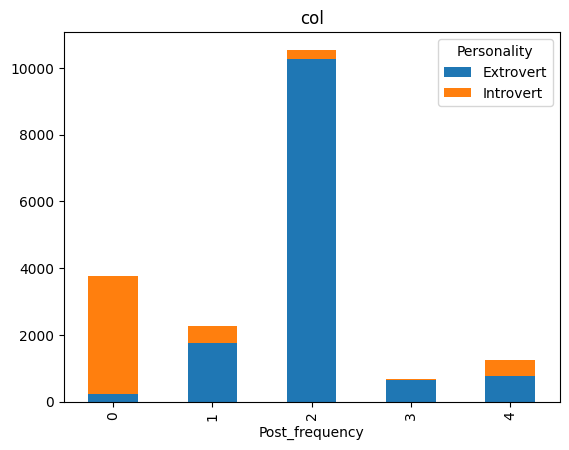

In [37]:
train_df.groupby(['Post_frequency','Personality']).size().unstack().plot(kind='bar', stacked=True, title='col')

## CATBOOST

In [66]:
train_df.columns

Index(['id', 'Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
       'Drained_after_socializing', 'Friends_circle_size', 'Post_frequency',
       'Personality', 'Drained_after_socializing_MISS', 'Soc_sub_Goi'],
      dtype='object')

In [134]:
X=train_df.drop([ 'id','Personality'], axis=1).copy()
y=train_df['Personality'].copy()

0:	learn: 0.6296363	total: 147ms	remaining: 36.6s
100:	learn: 0.1259267	total: 9.79s	remaining: 14.5s
200:	learn: 0.1223325	total: 21s	remaining: 5.12s
249:	learn: 0.1209063	total: 26.3s	remaining: 0us
0:	learn: 0.6291456	total: 150ms	remaining: 37.4s
100:	learn: 0.1225838	total: 8.95s	remaining: 13.2s
200:	learn: 0.1189275	total: 21.2s	remaining: 5.16s
249:	learn: 0.1177791	total: 26.3s	remaining: 0us
0:	learn: 0.6292770	total: 152ms	remaining: 37.8s
100:	learn: 0.1236334	total: 10s	remaining: 14.8s
200:	learn: 0.1202380	total: 21.5s	remaining: 5.25s
249:	learn: 0.1190301	total: 27.1s	remaining: 0us


In [135]:
cat_features = ['Drained_after_socializing','Time_spent_Alone','Social_event_attendance','Going_outside','Friends_circle_size', 'Post_frequency',
               'Soc_sub_Goi', 'Tim_sub_Soc', 'not_MISS_total',
                'Outside_mult_Friends', 'Time_Alone_dev_Outside' ] #, 'Outside_mult_Friends', 'Time_Alone_dev_Outside']

#'Drained_after_socializing', 'Outside_mult_Friends', 'Time_Alone_dev_Outside', 
# 1. Inicjalizacja modelu (bez uczenia, bez pipeline'u)Time_Alone_dev_Outside
model = CatBoostClassifier(random_seed=42,verbose=100, cat_features=cat_features)  # verbose=0 żeby nie spamował

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. Zbiór parametrów do przeszukania
param_grid = {
    'learning_rate': [ 0.04],#, 0.05, 0.1],
    'depth': [6],#, 8],
    #'l2_leaf_reg': [4,5,3,6],#, 3],
    'iterations': [  250], #opt 200
    #'auto_class_weights': ['SqrtBalanced', 'Balanced' ] #'Balanced', 'None', 
}

# 3. GridSearchCV (tu możesz dodać scoring, cv, n_jobs itd.)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',       # lub 'roc_auc', 'f1', zależnie od problemu
    cv=cv,                      # 5-fold cross-validation
    n_jobs=-1,                 # pełne równoległe obciążenie CPU
    return_train_score=True
)

# 4. Dopasowanie do danych (X to features, y to target)
grid_search.fit(X, y)

# 5. Wyniki
print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepszy wynik:", grid_search.best_score_)

best_model = grid_search.best_estimator_

# Ponowne fitowanie z cat_features
#best_model.set_params(cat_features=cat_features)
#best_model.fit(train_df.drop(['id','Personality'], axis=1), train_df['Personality'])
eval_pool = Pool(X, y, cat_features=cat_features)
importances = best_model.get_feature_importance(eval_pool)

res_df = pd.DataFrame(grid_search.cv_results_)
res_df[['rank_test_score','mean_test_score','mean_train_score','std_test_score','params']]

0:	learn: 0.6300833	total: 13.7ms	remaining: 3.4s
100:	learn: 0.1264752	total: 1.78s	remaining: 2.62s
200:	learn: 0.1235602	total: 4.19s	remaining: 1.02s
249:	learn: 0.1223167	total: 5.52s	remaining: 0us
Najlepsze parametry: {'depth': 6, 'iterations': 250, 'learning_rate': 0.04}
Najlepszy wynik: 0.9682701976097036


,rank_test_score,mean_test_score,mean_train_score,std_test_score,params
0,1,0.96827,0.972791,0.003291,"{'depth': 6, 'iterations': 250, 'learning_rate..."


<Figure size 1000x600 with 0 Axes>

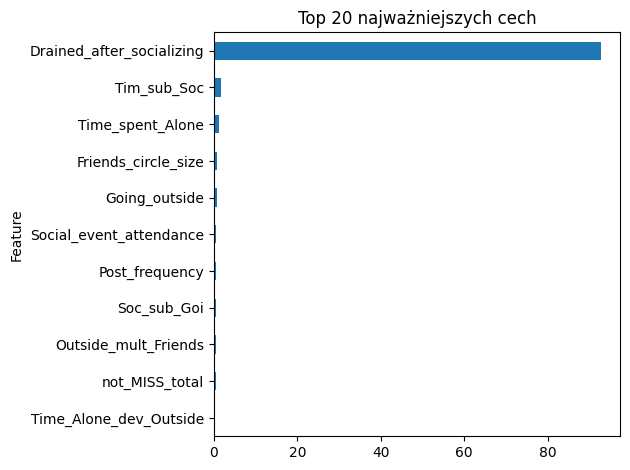

In [136]:
# Wyciągnięcie ważności cech
#importances = best_model.get_feature_importance(Pool(train_df.drop(['id','Personality'], axis=1), train_df['Personality']))
feature_names = X.columns

# DataFrame z ważnościami
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Wyświetlenie najważniejszych cech
plt.figure(figsize=(10, 6))
fi_df.head(30).plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.gca().invert_yaxis()
plt.title("Top 20 najważniejszych cech")
plt.tight_layout()
plt.show()

# OPtyna experiments

In [ ]:
import optuna
from catboost import CatBoostClassifier

def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "iterations": 500,
        "verbose": 0,
        "loss_function": "Logloss"
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_valid)[:,1]
    return roc_auc_score(y_valid, preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

best_params = study.best_params